In [214]:
%matplotlib inline
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
import re
import itertools
from matplotlib import pyplot as plt
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot

init_notebook_mode(connected=True)

## Preprocessing

In [215]:
# read in required data
data = pd.read_csv("this_is_america_comments_as_of_5142018.csv", encoding = "ISO-8859-1")

# keep only interesting columns
data = data[['Commentid','textOriginal','publishedAt','likeCount','totalReplyCount']]

data[100:105]

,Commentid,textOriginal,publishedAt,likeCount,totalReplyCount
100,Ugz2NTbrphEc7xspvr14AaABAg,#4 france,2018-05-08T02:42:15.000Z,0,0
101,UgySxoc7VxcoJDdj2cd4AaABAg,My interpretation is we ÒblacksÓ just want to ...,2018-05-08T02:42:11.000Z,0,4
102,UgwFktxLVarwnCMk4bV4AaABAg,I love the fact that heÕs always shirtless now,2018-05-08T02:42:09.000Z,0,0
103,Ugz4eiVIl0v6oDfFh694AaABAg,I always loved Gambino's absurdest aesthetic,2018-05-08T02:42:07.000Z,29,0
104,UgwOUMvXb8daqYwqr954AaABAg,@ 2:10 you can hear everyone in the background...,2018-05-08T02:42:00.000Z,0,0


In [216]:
# change date type
data['publishedAt'] = pd.to_datetime(data['publishedAt'],infer_datetime_format=True)

# add hour and day
data['day'] = data.publishedAt.dt.day
data['hour'] = data.publishedAt.dt.hour

In [217]:
# replace underscores
data['textOriginal'] = data['textOriginal'].str.replace('_', '')

# replace weird symbols with what they represent
data['textOriginal'] = data['textOriginal'].str.replace('Õ', "'")
data['textOriginal'] = data['textOriginal'].str.replace('Ò', '"')
data['textOriginal'] = data['textOriginal'].str.replace('Ó', '"')
data[100:105]

,Commentid,textOriginal,publishedAt,likeCount,totalReplyCount,day,hour
100,Ugz2NTbrphEc7xspvr14AaABAg,#4 france,2018-05-08 02:42:15,0,0,8,2
101,UgySxoc7VxcoJDdj2cd4AaABAg,"My interpretation is we ""blacks"" just want to ...",2018-05-08 02:42:11,0,4,8,2
102,UgwFktxLVarwnCMk4bV4AaABAg,I love the fact that he's always shirtless now,2018-05-08 02:42:09,0,0,8,2
103,Ugz4eiVIl0v6oDfFh694AaABAg,I always loved Gambino's absurdest aesthetic,2018-05-08 02:42:07,29,0,8,2
104,UgwOUMvXb8daqYwqr954AaABAg,@ 2:10 you can hear everyone in the background...,2018-05-08 02:42:00,0,0,8,2


In [218]:
# filter out NaN comments
data = data[data['textOriginal'].notnull()]

## EDA

In [219]:
data.dtypes

Commentid                  object
textOriginal               object
publishedAt        datetime64[ns]
likeCount                   int64
totalReplyCount             int64
day                         int64
hour                        int64
dtype: object

In [220]:
# get timestamps into list rounded to the nearest hour
timestamplist = data['publishedAt'].tolist()
timestamplist = [x.replace(second=0,minute=0) for x in timestamplist]

In [221]:
# create dictionary of hours
cnt = Counter()
for hour in timestamplist:
    cnt[hour] += 1

In [222]:
# put hours and count into sorted lists
hours = []
count_comments = []
for key in sorted(cnt):
    hours.append(key)
    count_comments.append(cnt[key])

In [223]:
data2 = [go.Scatter(x=hours, y=count_comments)]
layout = go.Layout(title='Number of Comments by Hour')
fig = go.Figure(data=data2, layout=layout)
plotly.offline.iplot(fig)

## Popular Times

In [224]:
# filter for comments that tagged a time
timedata = data[data['textOriginal'].str.contains('\d{1,2}:\d{2}')]['textOriginal'].tolist()

# get list of every tagged time in dataset
timeslist = list(itertools.chain.from_iterable([re.findall(r"\d{1,2}:\d{2}", x) for x in timedata]))

# remove bad times
timeslist = [x for x in timeslist if int(x.split(":")[0]) <= 4 or int(x.split(":")[1]) <=59]

In [225]:
# convert time to seconds
seconds = [int(x.split(":")[0])*60 + int(x.split(":")[1]) for x in timeslist]

#remove bad times again
seconds = [int(x) for x in seconds if x <=240]

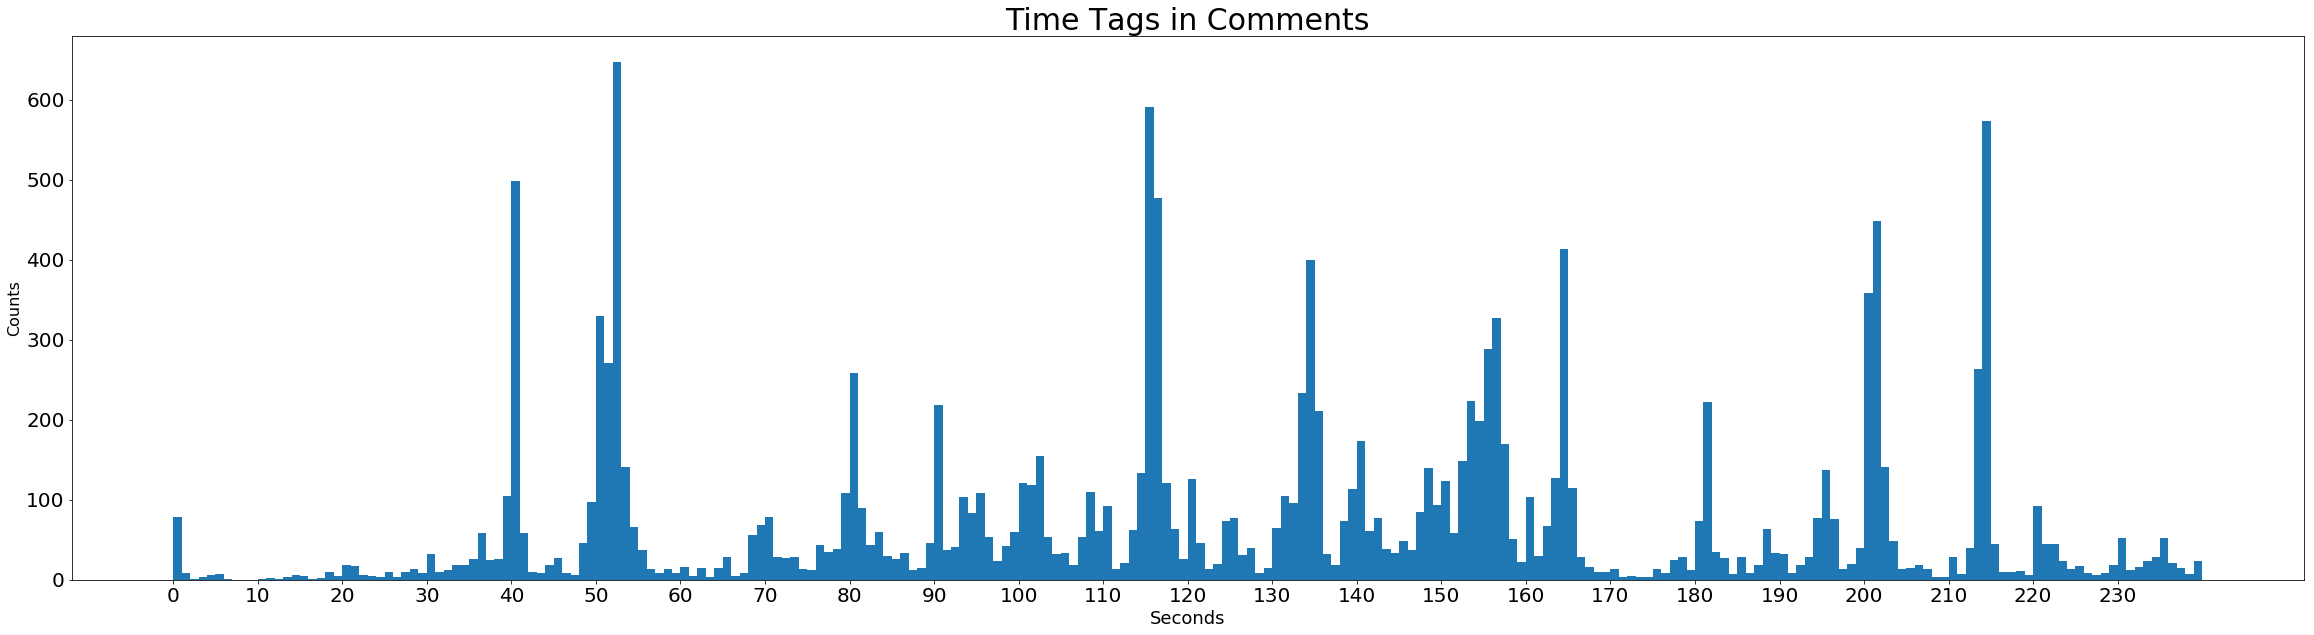

In [226]:
# histogram
plt.figure(figsize=(40,10));
plt.hist(seconds, bins=range(min(seconds), max(seconds) + 1, 1));
plt.xticks(np.arange(min(seconds),  max(seconds), step=10));
plt.tick_params(labelsize=20);
plt.title("Time Tags in Comments", fontsize=30);
plt.xlabel('Seconds', fontsize=18);
plt.ylabel('Counts', fontsize=16);

## Sentiment Analysis

In [227]:
# compile comments into a list
comment_list = data.textOriginal.tolist()

# remove numbers from documents
comment_list = [x for x in comment_list if type(x) != float]

In [228]:
# sentiment analysis
analyzer = SentimentIntensityAnalyzer()

sentiment_dict = {}
for i in comment_list:
    sentiment_dict[i] = analyzer.polarity_scores(i)

In [229]:
pos_dict = {}
neg_dict = {}
nuet_dict = {}
compound_dict = {}

for k, v in zip(sentiment_dict.keys(), sentiment_dict.values()):
    pos_dict[k]  = v['pos']
    neg_dict[k]  = v['neg']
    nuet_dict[k]  = v['neu']
    compound_dict[k]  = v['compound']
    
data['positive'] = data['textOriginal'].map(pos_dict)
data['negative'] = data['textOriginal'].map(neg_dict)
data['nuetral'] = data['textOriginal'].map(nuet_dict)
data['compound'] = data['textOriginal'].map(compound_dict)

In [230]:
data.head()

,Commentid,textOriginal,publishedAt,likeCount,totalReplyCount,day,hour,positive,negative,nuetral,compound
0,UgyqB8uZ9wtGrX9SWO14AaABAg,first,2018-05-06 04:01:36,0,0,6,4,0.000,0.000,1.000,0.0000
1,UgwHW8MnT4snWYWhZz54AaABAg,ily,2018-05-06 04:01:35,0,0,6,4,1.000,0.000,0.000,0.6597
2,Ugz55_R4ocU4shaiZeZ4AaABAg,Childish Gambino is one of the greatest artist...,2018-05-06 04:01:35,10,0,6,4,0.256,0.134,0.610,0.4588
3,UgwLSaxmvmntAa1v4nJ4AaABAg,No way bro!!!!,2018-05-06 04:01:34,1,0,6,4,0.000,0.627,0.373,-0.5216
4,UgzpuaTGtDYOt6B8b8h4AaABAg,HES ALIVEEEE,2018-05-06 04:01:34,1,0,6,4,0.000,0.000,1.000,0.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a411b7668>]],
      dtype=object)

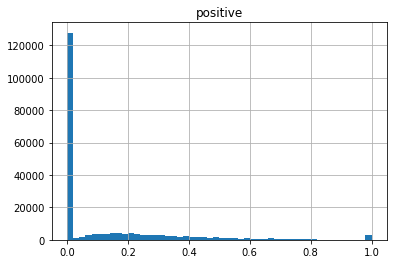

In [231]:
data.hist(column='positive', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a36e2ad68>]],
      dtype=object)

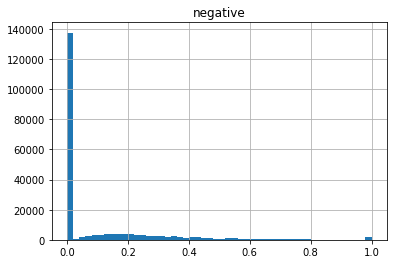

In [232]:
data.hist(column='negative', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4330dba8>]],
      dtype=object)

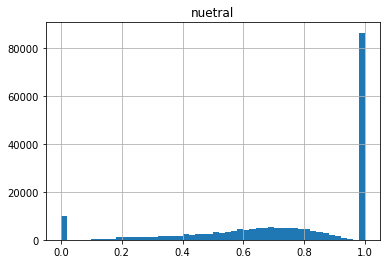

In [233]:
data.hist(column='nuetral', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4032dc18>]],
      dtype=object)

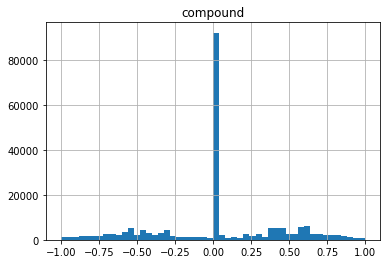

In [234]:
data.hist(column='compound', bins=50)

## LDA

In [247]:
def topic_modeling(doc_set, num_topics = 6):
    
    # remove words only appearing once in whole list
    # https://stackoverflow.com/questions/21100903/improve-performance-remove-all-strings-in-a-big-list-appearing-only-once
    c = Counter(word for x in doc_set for word in x.split())
    doc_set = [' '.join(y for y in x.split() if c[y] > 1) for x in doc_set]
    
    #remove numbers
    doc_set = [re.sub(r'/d+', '', w) for w in doc_set]

    #create tokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    # create English stop words list
    en_stop = get_stop_words('en')

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    # list for tokenized documents in loop
    texts = []

    # loop through document list
    for i in doc_set:
        
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        
        # add tokens to list
        texts.append(stemmed_tokens) # texts is a list of list of tokens for each doc (feedback response)
    
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # generate LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word = dictionary, 
                                           passes=20, minimum_probability=0)
    return ldamodel, corpus

In [262]:
long_comments = [x for x in data.textOriginal.tolist() if len(x) > 75]
long_comments = [''.join([i for i in w if not i.isdigit()]) for w in long_comments]

In [242]:
ldamodel, corpus = topic_modeling(doc_set = long_comments, num_topics = 6)
for top in ldamodel.print_topics(num_words=6):
    print(top)

(0, '0.041*"video" + 0.026*"song" + 0.024*"s" + 0.022*"like" + 0.017*"music" + 0.016*"just"')
(1, '0.103*"yeah" + 0.057*"man" + 0.053*"black" + 0.053*"get" + 0.041*"money" + 0.032*"m"')
(2, '0.102*"wiggl" + 0.102*"meme" + 0.013*"right" + 0.009*"3" + 0.007*"guy" + 0.006*"anybodi"')
(3, '0.024*"danc" + 0.017*"shoot" + 0.016*"2" + 0.015*"s" + 0.012*"notic" + 0.012*"background"')
(4, '0.030*"peopl" + 0.030*"black" + 0.029*"america" + 0.021*"s" + 0.010*"white" + 0.010*"us"')
(5, '0.026*"de" + 0.025*"que" + 0.023*"o" + 0.015*"s" + 0.015*"n" + 0.015*"la"')


In [243]:
ldamodel, corpus = topic_modeling(doc_set = long_comments,num_topics = 10)
for top in ldamodel.print_topics(num_words=6):
    print(top)

(0, '0.049*"childish" + 0.046*"gambino" + 0.033*"rapper" + 0.025*"21" + 0.023*"young" + 0.021*"thug"')
(1, '0.107*"yeah" + 0.055*"man" + 0.054*"get" + 0.054*"black" + 0.041*"money" + 0.032*"m"')
(2, '0.068*"2" + 0.055*"1" + 0.039*"trend" + 0.032*"3" + 0.027*"view" + 0.023*"youtub"')
(3, '0.063*"song" + 0.055*"video" + 0.051*"wiggl" + 0.046*"music" + 0.028*"messag" + 0.021*"s"')
(4, '0.104*"america" + 0.026*"countri" + 0.021*"american" + 0.018*"world" + 0.013*"african" + 0.013*"live"')
(5, '0.044*"black" + 0.042*"peopl" + 0.024*"america" + 0.024*"s" + 0.015*"white" + 0.012*"violenc"')
(6, '0.050*"video" + 0.038*"meme" + 0.034*"watch" + 0.031*"s" + 0.027*"time" + 0.020*"like"')
(7, '0.023*"like" + 0.020*"s" + 0.018*"shit" + 0.018*"fuck" + 0.016*"just" + 0.015*"can"')
(8, '0.031*"danc" + 0.026*"shoot" + 0.019*"gun" + 0.017*"s" + 0.016*"end" + 0.015*"run"')
(9, '0.036*"de" + 0.034*"que" + 0.032*"o" + 0.020*"n" + 0.020*"la" + 0.019*"e"')


In [249]:
ldamodel, corpus = topic_modeling(doc_set = long_comments,num_topics = 7)
for top in ldamodel.print_topics(num_words=6):
    print(top)

(0, '0.036*"video" + 0.031*"song" + 0.024*"like" + 0.023*"s" + 0.018*"music" + 0.016*"just"')
(1, '0.079*"meme" + 0.070*"watch" + 0.056*"time" + 0.037*"video" + 0.030*"trend" + 0.023*"view"')
(2, '0.097*"yeah" + 0.049*"black" + 0.048*"get" + 0.047*"man" + 0.038*"money" + 0.029*"just"')
(3, '0.124*"wiggl" + 0.025*"de" + 0.024*"que" + 0.022*"o" + 0.014*"n" + 0.014*"s"')
(4, '0.029*"s" + 0.022*"peopl" + 0.019*"america" + 0.013*"video" + 0.012*"us" + 0.011*"gun"')
(5, '0.021*"shoot" + 0.019*"danc" + 0.016*"2" + 0.015*"gun" + 0.015*"s" + 0.013*"car"')
(6, '0.110*"black" + 0.052*"america" + 0.043*"peopl" + 0.036*"white" + 0.017*"kill" + 0.013*"american"')


In [250]:
ldamodel, corpus = topic_modeling(doc_set = long_comments,num_topics = 8)
for top in ldamodel.print_topics(num_words=6):
    print(top)

(0, '0.107*"yeah" + 0.056*"man" + 0.053*"get" + 0.053*"black" + 0.042*"money" + 0.032*"m"')
(1, '0.023*"black" + 0.022*"gun" + 0.019*"shoot" + 0.016*"s" + 0.015*"danc" + 0.014*"end"')
(2, '0.036*"like" + 0.035*"meme" + 0.033*"song" + 0.024*"s" + 0.023*"shit" + 0.022*"just"')
(3, '0.047*"video" + 0.020*"s" + 0.019*"music" + 0.017*"watch" + 0.017*"time" + 0.017*"song"')
(4, '0.029*"de" + 0.027*"que" + 0.025*"o" + 0.016*"n" + 0.016*"s" + 0.016*"la"')
(5, '0.040*"america" + 0.040*"black" + 0.038*"peopl" + 0.016*"white" + 0.012*"s" + 0.012*"countri"')
(6, '0.107*"wiggl" + 0.056*"2" + 0.045*"1" + 0.025*"3" + 0.024*"21" + 0.021*"young"')
(7, '0.036*"s" + 0.026*"danc" + 0.021*"video" + 0.020*"go" + 0.018*"happen" + 0.018*"distract"')


In [251]:
ldamodel, corpus = topic_modeling(doc_set = long_comments,num_topics = 15)
for top in ldamodel.print_topics(num_words=6):
    print(top)

(0, '0.048*"gambino" + 0.040*"donald" + 0.039*"childish" + 0.034*"glover" + 0.027*"video" + 0.019*"s"')
(1, '0.011*"god" + 0.011*"crap" + 0.011*"strong" + 0.011*"woke" + 0.010*"free" + 0.010*"will"')
(2, '0.080*"song" + 0.048*"video" + 0.048*"music" + 0.030*"like" + 0.025*"s" + 0.024*"messag"')
(3, '0.023*"expect" + 0.022*"wait" + 0.020*"half" + 0.020*"less" + 0.019*"chill" + 0.018*"war"')
(4, '0.065*"video" + 0.057*"meme" + 0.050*"watch" + 0.034*"time" + 0.023*"like" + 0.023*"just"')
(5, '0.050*"shit" + 0.049*"fuck" + 0.031*"like" + 0.022*"get" + 0.017*"u" + 0.017*"im"')
(6, '0.107*"yeah" + 0.052*"wiggl" + 0.052*"man" + 0.051*"get" + 0.049*"black" + 0.040*"money"')
(7, '0.045*"21" + 0.045*"young" + 0.038*"thug" + 0.037*"rapper" + 0.035*"savag" + 0.034*"hear"')
(8, '0.096*"black" + 0.050*"peopl" + 0.032*"white" + 0.027*"gun" + 0.019*"america" + 0.019*"kill"')
(9, '0.113*"trend" + 0.057*"youtub" + 0.036*"1" + 0.023*"lil" + 0.019*"million" + 0.015*"http"')
(10, '0.075*"2" + 0.046*"3" + 0

In [263]:
ldamodel, corpus = topic_modeling(doc_set = long_comments,num_topics = 20)
for top in ldamodel.print_topics(num_words=6):
    print(top)

(0, '0.114*"yeah" + 0.055*"get" + 0.055*"man" + 0.052*"black" + 0.043*"money" + 0.033*"m"')
(1, '0.032*"car" + 0.027*"s" + 0.023*"danc" + 0.023*"shot" + 0.023*"guy" + 0.019*"man"')
(2, '0.164*"meme" + 0.100*"gambino" + 0.072*"childish" + 0.051*"donald" + 0.035*"glover" + 0.016*"talent"')
(3, '0.137*"fuck" + 0.109*"shit" + 0.031*"ass" + 0.027*"hit" + 0.024*"oh" + 0.023*"woke"')
(4, '0.046*"de" + 0.043*"que" + 0.041*"o" + 0.027*"n" + 0.026*"la" + 0.024*"e"')
(5, '0.061*"s" + 0.055*"like" + 0.032*"just" + 0.027*"m" + 0.026*"say" + 0.025*"video"')
(6, '0.082*"time" + 0.072*"watch" + 0.057*"video" + 0.034*"ve" + 0.027*"trend" + 0.024*"view"')
(7, '0.027*"ya" + 0.024*"jesu" + 0.019*"peac" + 0.019*"bitch" + 0.017*"product" + 0.014*"blood"')
(8, '0.042*"will" + 0.014*"human" + 0.014*"histori" + 0.013*"american" + 0.011*"cultur" + 0.010*"never"')
(9, '0.031*"video" + 0.028*"s" + 0.026*"art" + 0.021*"artist" + 0.020*"donald" + 0.019*"music"')
(10, '0.066*"can" + 0.038*"video" + 0.036*"know" + 0.

In [264]:
ldamodel, corpus = topic_modeling(doc_set = long_comments,num_topics = 18)
for top in ldamodel.print_topics(num_words=6):
    print(top)

(0, '0.083*"watch" + 0.083*"video" + 0.071*"time" + 0.032*"ve" + 0.021*"first" + 0.020*"mani"')
(1, '0.144*"fuck" + 0.122*"shit" + 0.033*"ass" + 0.021*"garbag" + 0.020*"bullshit" + 0.020*"nigga"')
(2, '0.055*"love" + 0.025*"video" + 0.025*"music" + 0.020*"art" + 0.020*"artist" + 0.018*"s"')
(3, '0.048*"s" + 0.047*"like" + 0.037*"peopl" + 0.034*"don" + 0.033*"video" + 0.031*"just"')
(4, '0.114*"yeah" + 0.055*"man" + 0.055*"get" + 0.052*"black" + 0.043*"money" + 0.033*"m"')
(5, '0.202*"america" + 0.058*"countri" + 0.026*"world" + 0.024*"live" + 0.022*"american" + 0.017*"best"')
(6, '0.167*"meme" + 0.126*"gambino" + 0.087*"donald" + 0.074*"childish" + 0.065*"glover" + 0.018*"geniu"')
(7, '0.097*"song" + 0.049*"video" + 0.045*"music" + 0.036*"like" + 0.027*"s" + 0.027*"messag"')
(8, '0.049*"gun" + 0.036*"car" + 0.035*"someon" + 0.032*"anyon" + 0.028*"end" + 0.025*"guy"')
(9, '0.050*"young" + 0.043*"thug" + 0.040*"savag" + 0.035*"hear" + 0.035*"rapper" + 0.025*"ad"')
(10, '0.015*"commentari